# Basic Natural Language Processing (NLP)

In this lab, we will process some tweets that include "#covid19" to obtain their normalized versions which can be used in various analyses. The dataset we will use is obtained through filtering out non-complete tweets of [a public Kaggle dataset](https://www.kaggle.com/gpreda/covid19-tweets). You can later apply the same processes to your own datasets.

## Contents
* [Google Colab](#colab)
* [Importing and cleaning data](#data)
* [NLTK](#nltk)
* [Tokenization](#token)
* [Part-of-speech](#pos)
* [Stemming and lemmatization](#stem-lemma)
* [Negation handling](#negation)
* [Pulling everything together](#everything)
* [Sentiment analysis](#sentiment)
* [Bonus: Levenshtein distance](#levenshtein)
* [Bonus: NLP with Turkish](#tr)
    * [Stemming](#tr-stem)
    * [POS tagging and lemmatization](#tr-pos-lemma)
    * [Dealing with Turkish characters](#tr-encoding)
* [More information](#more-info)

## Google Colab<a id="colab"></a>

If you are running this notebok on Google Colab, you need to run the cell below. It will install the packages we will use and mount your Google Drive in order to access the dataset. Follow the Google link it will provide, copy the authorization code, paste it in the box, and press enter.

In [1]:
!pip install contractions
!pip install langdetect
!pip install autocorrect
!pip install emoji
!pip install python-Levenshtein
!pip install snowballstemmer
!pip install zeyrek

     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 284 kB 39.9 MB/s 
     |████████████████████████████████| 981 kB 5.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=e8244046eebd67cde9ee007270219a02647489620a5b5beb3347f92b36b30189
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 622 kB 5.4 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=6b157b360d69132f9499c6162f690a6ec22bab61555b4316997a6e94f7cd10f6
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
     |████████████████████████████████| 175 kB 5.2 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=14870de34405ba5b220664d9b782a888e3c

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##Regex

When we need to modify text files before further processing, we could utilize python's string default string methods. These methods allow us to do some simple operations on our input strings.

In [3]:
dum_text = "look_here"
dum_text.split(r"_")

['look', 'here']

In [4]:
dum_text.upper()

'LOOK_HERE'

In [5]:
dum_text.find("oo")

1

Although Python's default operations help us in essential modifications, we need to utilize regular expressions. For this purpose, we will use the `re` library to use our regular expression patterns on an input text. `re` library gives different options to utilize regular expressions like search(), findall(), sub(), and split(). Let's check few of them

In [6]:
import re
print(re.match("my","findmyphone"))
re.match("findmyphone","findmyphone")

None


<re.Match object; span=(0, 11), match='findmyphone'>

In [7]:
re.search(r'Co.k.e', 'Cookie').group()

'Cookie'

In [8]:
re.findall(r'[0-9]','2 times 3 is equalto 6')

['2', '3', '6']

In [9]:
re.sub("small","big",'This tree is small.')

'This tree is big.'

## Importing and cleaning data<a id="data"></a>

In [19]:
import pandas as pd
import html
import contractions

# Importing it using Pandas (change the path as necessary):
dataset = pd.read_csv("/content/gdrive/MyDrive/Deep Learning for TA/NLP Basics/covid19_tweets_filtered.csv")

# The function we had also used while collecting some tweets, contraction
# expansion feature added:
def simplify_text(text):
    # Replaces line breaks or other whitespace characters with a single space:
    text = " ".join(text.split())
    
    # Unescapes HTML so that characters like "&" are displayed correctly:
    text = html.unescape(text)
    
    # Expands English contractions. Example: "let's" -> "let us"
    # Note that it may not yield the correct result with an ambigurous 
    # contraction such as "he's" (it could be "he is" or "he has").
    # By the way, it does not preserve letter cases, but we were going to 
    # lowercase them anyway.
    text = contractions.fix(text)
    
    return text

# It looks like tweets do not require HTML-unescaping anyway, but applying 
# simplify_text() to all texts should at least get rid of unnecessary whitespace:
dataset["text"] = dataset["text"].map(simplify_text)

# This option will automatically set the column width when we display data:
pd.set_option('display.max_colwidth', 0)

# Taking a look at the tweet contents:
dataset["text"].head(n=50)

0     Praying for good health and recovery of @ChouhanShivraj . #covid19 #covidPositive                                                           
1     July 25 #COVID19 update #TamilNadu - 6988 Discharge- 7758 People tested - 61729 Actice cases - 52273 #chennai - 1329                        
2     Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN                                                
3     Holy water in times of #COVID19 https://t.co/YaZ49yxL27                                                                                     
4     #FEMA acknowledges #PuertoRico lacks rebuilt homes and a hospital to survive #COVID19 https://t.co/PLXqKc5K5d                               
5     Actionables for a healthy recovery from #COVID19 #climate https://t.co/crGlKZOz5Z                                                           
6     Volume for those at the back please. 🔊 #COVID19 https://t.co/d0pn2Bv2Hx                                         

We can easily read these tweets, but they are far from being suitable for analysis.

We can filter tweets by language using the API, and our dataset is _seemingly_ made of tweets written in English, but it can be a good idea to check their language on our end before analysis. For this, we can use langdetect package and see if there is a text that is not detected to be in English. However, these approaches may not always work, especially with noisy text:

In [20]:
from langdetect import detect  ## >5m runtime

def detect_tweet_lang(tweet):
    # This roughly removes user handles and URLs:
#     tweet = ' '.join(re.sub("(@[A-Za-z0-9_\-]+ )|(https?:\/\/.* )|(www\..* )"," ",tweet).split())
    try:
        lang = detect(tweet)
    except:
        lang = ""
        
    return lang

dataset["lang"] = dataset["text"].map(detect_tweet_lang)

# Summarizes detected language counts:
dataset["lang"].value_counts()

en    39582
it    140  
fr    120  
es    112  
de    101  
id    73   
et    69   
ca    63   
af    60   
ro    55   
nl    48   
pt    40   
tl    39   
sv    36   
no    31   
so    24   
da    24   
cy    19   
sw    14   
fi    10   
hr    10   
sl    8    
lt    8    
      7    
pl    7    
vi    7    
tr    7    
ar    5    
sk    3    
ja    3    
lv    3    
sq    2    
fa    1    
cs    1    
ru    1    
el    1    
hu    1    
ko    1    
Name: lang, dtype: int64

Many other languages are detected as well. However, it looks like they are not accurate:

In [21]:
# Retrieves the text and detected language of the first 20 tweets that are 
# seemingly not in English:
dataset.loc[dataset["lang"] != "en",["text", "lang"]].head(20)

,text,lang
89,@stayingupszn When did I ask? #COVID19 #katiehopkins #LUFC,af
206,I love You !!!😘😘😘 #DJSBU #COVID19 https://t.co/xzKOqrAA6m,cs
348,Emptiness #cosasqueveo #COVID19 https://t.co/sgye0XMFBu,pt
467,@drdavidsamadi BECAUSE IT IS RACIST AS FUCK! #Covid19,id
478,Go away #COVID19 ! →https://t.co/ou0tvwKsVF https://t.co/1qR4ealkBp,so
500,🦠Covid-19 #votresanté #COVID19 🦠 https://t.co/zYmwFIUTvu,fr
554,833-917-2880. ANSWER THE CALL! #Florida #COVID19 https://t.co/L8sNC6kDNj,pt
560,Pakistan vs India Yes we won 🇵🇰 #COVID19 @MasudAKhan6 @panku_ @MajorPoonia @GeneralBakshi https://t.co/vqNTnItsUX,id
566,Corona Baba booked in Hyderabad #CoronaBaba #Hyderabad #COVID19 https://t.co/B8bsXAMOuv,so
577,Fun fact 🐈 #ketamine #covid19 #covid #coronvirus #coronavirusmemes https://t.co/rIuyKOJ0He,es


A very small percentage is indeed in a different language, but the rest are being misclassified even when we remove URLs and user handles before checking, or look at the top three possible languages using `detect_langs()` from the same package. Fortunately, the percentage is not that significant. If you want, you can remove these tweets from your dataset just to be sure:

In [22]:
# Run this if you insist on removing tweets that "appear" to be written in a 
# different language.
# dataset = dataset[dataset["lang"] == "en"]

## NLTK<a id="nltk"></a>

For NLP with English texts, we will mostly use Natural Language Toolkit (NLTK) package. It is one of the most popular NLP packages for Python, and it has many useful tools. If you have Anaconda, it should come with it. If you do not have it, check [this](https://riptutorial.com/nltk#installation-or-setup) page for installation. We also need to manually download some datasets that it will use. If you have not already downloaded them, run the cell below:

In [23]:
from nltk import download
download("popular") # Popular datasets
download('tagsets') # Tagsets for POS tagging
download('vader_lexicon') # Lexicon for sentiment analysis

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

## Tokenization<a id="token"></a>

To be able to analyze the data, we need to split each text into small units. This process is called "tokenization." It is mostly done by splitting the text using whitespace and punctuation, but there are different tokenizers that handle certain details slightly differently. NLTK has a tweet-specific tokenizer that preserves "#" and "@" characters while other tokenizers can mess up Twitter-specific notations. See how tweets are tokenized below:

In [24]:
from nltk.tokenize import TweetTokenizer

# This tokenizer will tokenize tweets. "preserve_case" parameter can be used to 
# preserve cases or make it all lowercase. "reduce_len" parameter shortens
# consecutive character repetitions to at most three consecutive repetitions to
# reduce noise.
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

for tweet in dataset["text"].head():
    print(tweet,"\n└─>",tokenizer.tokenize(tweet),"\n")

Praying for good health and recovery of @ChouhanShivraj . #covid19 #covidPositive 
└─> ['praying', 'for', 'good', 'health', 'and', 'recovery', 'of', '@chouhanshivraj', '.', '#covid19', '#covidpositive'] 

July 25 #COVID19 update #TamilNadu - 6988 Discharge- 7758 People tested - 61729 Actice cases - 52273 #chennai - 1329 
└─> ['july', '25', '#covid19', 'update', '#tamilnadu', '-', '6988', 'discharge', '-', '7758', 'people', 'tested', '-', '61729', 'actice', 'cases', '-', '52273', '#chennai', '-', '1329'] 

Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN 
└─> ['second', 'wave', 'of', '#covid19', 'in', 'flanders', '..', 'back', 'to', 'more', '#homework', 'again', '...', 'https://t.co/9swImZACMN'] 

Holy water in times of #COVID19 https://t.co/YaZ49yxL27 
└─> ['holy', 'water', 'in', 'times', 'of', '#covid19', 'https://t.co/YaZ49yxL27'] 

#FEMA acknowledges #PuertoRico lacks rebuilt homes and a hospital to survive #COVID19 https://t.co/PLXqKc5K5d

## Part-of-speech<a id="pos"></a>

Before we move along, we should take a look at part-of-speech (commonly referred as "POS") tagging. Sometimes we need to classify words according to their function (part-of-speech) in the sentence, so that we can extract certain information. For example, if we need to analyze verbs in a long text, we can use words' POS tags and filter out words that are not verbs, which would significantly simplify the process. POS tags are especially useful when a word can have different functions in a sentence with the exact same form, so we cannot just take a look at the word itself and draw conclusions. For example, "type" can mean a category or a verb (to type). For these reasons, we have POS taggers. A POS tagger classifies each unit's syntactic function in the sentence. There are different types of POS taggers. The one we will use is actually a pre-trained machine learning classifier of NLTK. The perceptron model is trained with a [treebank](https://en.wikipedia.org/wiki/Treebank) (a corpus with annotated POS tags).

In [25]:
from nltk import pos_tag

sentence = "Which type of typewriter would you like to type with?"

# Uppercase letters can confuse POS tagging, so we need to lowercase everything. This 
# is automatically handled by our tokenizer anyway. Note that a truecasing approach or 
# a more simplified approach such as only touching the first letter of a sentence could 
# potentially yield better results in POS tagging. You can check 
# https://en.wikipedia.org/wiki/Truecasing and 
# https://towardsdatascience.com/truecasing-in-natural-language-processing-12c4df086c21
# to read more about truecasing.
sentence_tokens = tokenizer.tokenize(sentence)

# POS tagging:
sentence_tokens_pos = pos_tag(sentence_tokens)

print(sentence_tokens_pos)

[('which', 'WDT'), ('type', 'NN'), ('of', 'IN'), ('typewriter', 'NN'), ('would', 'MD'), ('you', 'PRP'), ('like', 'VB'), ('to', 'TO'), ('type', 'VB'), ('with', 'IN'), ('?', '.')]


As you can see, each term is now classified. However, the tags are not very clear for us. We can check the documentation or use a dictionary to read the explanation and see some examples:

In [26]:
from nltk.data import load
tag_dict = load('help/tagsets/upenn_tagset.pickle')

for token in sentence_tokens_pos:
    print("Token:",token[0],"\nPOS tag:",token[1],"\nExplanation:",tag_dict[token[1]][0],"\nExample:",tag_dict[token[1]][1],"\n")

Token: which 
POS tag: WDT 
Explanation: WH-determiner 
Example: that what whatever which whichever  

Token: type 
POS tag: NN 
Explanation: noun, common, singular or mass 
Example: common-carrier cabbage knuckle-duster Casino afghan shed thermostat investment slide humour falloff slick wind hyena override subhumanity machinist ...  

Token: of 
POS tag: IN 
Explanation: preposition or conjunction, subordinating 
Example: astride among uppon whether out inside pro despite on by throughout below within for towards near behind atop around if like until below next into if beside ...  

Token: typewriter 
POS tag: NN 
Explanation: noun, common, singular or mass 
Example: common-carrier cabbage knuckle-duster Casino afghan shed thermostat investment slide humour falloff slick wind hyena override subhumanity machinist ...  

Token: would 
POS tag: MD 
Explanation: modal auxiliary 
Example: can cannot could couldn't dare may might must need ought shall should shouldn't will would  

Token: y

See that the first "type" is classified as a noun ("NN") while the last one is classified as a verb ("VB"). It is not bad for general purposes. This will come handy later.

## Stemming and lemmatization<a id="stem-lemma"></a>

Consider these two sentences:
* Vegetables are healthy.
* This vegetable is healthier.

They both are about vegetables being healthy, but the words do not exactly occur in the same form ("vegetables" vs. "vegetable" and "healthy" vs. "healthier"). We need to simplify and conflate them to improve our analyses. One easy way to simplify words is using a stemmer. Stemmers rely on certain language-specific linguistic rules and sets of suffixes to get rid of suffixes (such as "tional" or "ism") and find the stem (root) of each word. Just like tokenizers, there are different stemmers. We will use Snowball stemmer included in NLTK here. To learn more about the original Snowball stemmer algorithm and its implementation, you can look at [this web page](http://snowball.tartarus.org/algorithms/porter/stemmer.html). See how these sentences are stemmed below:

In [27]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

sentences = ["Vegetables are healthy.", "This vegetable is healthier."]

for sentence in sentences:
    sentence_tokens = tokenizer.tokenize(sentence)
    sentence_stems = [stemmer.stem(token) for token in sentence_tokens]
    print(sentence_stems)

['veget', 'are', 'healthi', '.']
['this', 'veget', 'is', 'healthier', '.']


It did not exactly work for "healthier" the way we expected. Vegetables are now in the same form ("veget"), but we may not prefer to stem these words all the way to their etymologic roots. Look what happens when we use stemming with this sentence:
* Vegetation is an assemblage of plant species.

In [28]:
[stemmer.stem(token) for token in tokenizer.tokenize("Vegetation is an assemblage of plant species.")]

['veget', 'is', 'an', 'assemblag', 'of', 'plant', 'speci', '.']

"Vegetation" becomes "veget" as well. This is not wrong, but probably not what we were going for either. Instead, we can use lemmatization. Lemmatization is the process of obtaining a word's base form. It is more complex than stemming, and it can also use a term's POS tag to determine the correct form. If you do not provide a POS tag, it assumes the term is a noun. One problem is that we cannot directly feed the tag we obtain through `pos_tag()` to the lemmatizer, so we need to write a function to simplify the tag and pas it in the form it requires.

In [29]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

lemmatizer = WordNetLemmatizer()

def get_lemmatizer_pos(pos):
    pos_start = pos[0] # Takes the first letter to simplify the POS tag
    if pos_start == "J":
        return wn.ADJ
    elif pos_start == "V":
        return wn.VERB
    elif pos_start == "R":
        return wn.ADV
    else:
        return wn.NOUN 

sentences = ["Vegetables are healthy.", "This vegetable is healthier.", "Vegetation is an assemblage of plant species."]

for sentence in sentences:
    # Lemmatization does not automatically converts it to lowercase, so we are manually 
    # doing it here:
    sentence_tokens = tokenizer.tokenize(sentence)
    sentence_tokens_pos = pos_tag(sentence_tokens)
#     print(sentence_tokens_pos)
    # Notice that we pass a token's POS tag to the lemmatizer through get_lemmatizer_pos()
    sentence_lemmas = [lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in sentence_tokens_pos]
    # Uncomment the line below to see how it works when we do not provide a POS tag (it 
    # lowers the success):
#     sentence_lemmas = [lemmatizer.lemmatize(token[0]) for token in sentence_tokens_pos]
    print(sentence_lemmas)

['vegetable', 'be', 'healthy', '.']
['this', 'vegetable', 'be', 'healthy', '.']
['vegetation', 'be', 'an', 'assemblage', 'of', 'plant', 'specie', '.']


* "vegetables" and "vegetable" become "vegetable" while "vegetation" is not conflated with them.
* "healthy" and "healthier" become "healthy."
* "is" and "are" become "be."

Note that lemmatization may not always work correctly either.

## Negation handling<a id="negation"></a>

What if we have a negation? Consider the following sentences:

* Butter is healthy.
* Butter is not healthy.

While it is clear for us that one is the opposite of the other, this can get tricky after tokenization:

In [30]:
sentences = ["Butter is healthy.", "Butter is not healthy."]

for sentence in sentences:
    sentence_tokens_pos = pos_tag(tokenizer.tokenize(sentence))
    sentence_lemmas = [lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in sentence_tokens_pos]
    print(sentence_lemmas)

['butter', 'be', 'healthy', '.']
['butter', 'be', 'not', 'healthy', '.']


Assume that we have many comments on butter and we want to analyze the answers to decide whether butter is healthy. If we simply look at the word occurrences, the word "healthy" occurs twice here, but one of the sentences actually states that butter is not healthy. Negations could mess up some analyses and go unnoticed. To quickly deal with it, we can handle negations using `mark_negation()`.

In [31]:
from nltk.sentiment.util import mark_negation

for sentence in sentences:
    sentence_tokens_pos = pos_tag(tokenizer.tokenize(sentence))
    sentence_lemmas = [lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in sentence_tokens_pos]
    # Negations are marked here:
    sentence_lemmas_negated = mark_negation(sentence_lemmas)
    print(sentence_lemmas_negated)

['butter', 'be', 'healthy', '.']
['butter', 'be', 'not', 'healthy_NEG', '.']


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Notice that the second "healthy" is now "healthy_NEG."

What if we have a more complex sentences? The negation only applies to "healthy" in these sentences:
* Butter is not healthy but delicious.
* Butter is not healthy, but it is delicious.
* Butter is not healthy. However, it is delicious.

However, it is not that smart:

In [32]:
sentences = ["Butter is not healthy but delicious.", "Butter is not healthy, but it is delicious.", "Butter is not healthy. However, it is delicious."]

for sentence in sentences:
    sentence_tokens_pos = pos_tag(tokenizer.tokenize(sentence))
    sentence_lemmas = mark_negation([lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in sentence_tokens_pos])
    print(sentence_lemmas)

['butter', 'be', 'not', 'healthy_NEG', 'but_NEG', 'delicious_NEG', '.']
['butter', 'be', 'not', 'healthy_NEG', ',_NEG', 'but_NEG', 'it_NEG', 'be_NEG', 'delicious_NEG', '.']
['butter', 'be', 'not', 'healthy_NEG', '.', 'however', ',', 'it', 'be', 'delicious', '.']


All consequent tokens up until the sentence terminator (such as period) are marked. Although the sentences state that butter is delicious, it is marked as negated in the first and the second sentences.

It can also handle words like "never," but it cannot handle implicit or subtle negations. These problems require more sophisticated approaches. Sarcasm detection is a research field by itself in NLP.

In [33]:
sentences = ["Butter is never healthy.", # Negated
             "Butter is rarely healthy.", # Mostly unhealthy
             "Yeah, sure, butter is healthy." # Sarcastic
            ]

for sentence in sentences:
    sentence_tokens_pos = pos_tag(tokenizer.tokenize(sentence))
    sentence_lemmas = mark_negation([lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in sentence_tokens_pos])
    print(sentence_lemmas)

['butter', 'be', 'never', 'healthy_NEG', '.']
['butter', 'be', 'rarely', 'healthy', '.']
['yeah', ',', 'sure', ',', 'butter', 'be', 'healthy', '.']


At this point, you have probably realized that these basic approaches are not fool-proof. We rely on these methods to work correctly _most of the time_.

## Pulling everything together<a id="everything"></a>

We can now combine these methods to normalize the tweets in our dataset. However, note that tweets have many other elements to consider as well:

* Hashtags
* User handles (usernames)
* URLs
* Numbers
* Stop words (like "the" and "is")
* Emojis
* Punctuations
* Typographic errors

In certain cases, we cannot learn much from them, so removing them would reduce the noise. In some cases, they can provide valuable information. For example, emojis can convey a message, so one might prefer to keep them. While some of the elements would wildly vary and make too much noise, indicators for their existence could be helpful as well. So, we could conflate them under a general type-specific token such as "\<number\>." Keeping specific user handles could come handy for social network analysis, but our focus here is text analysis. The existence of a question or exclamation mark can be informative as well, but we will not specifically analyze them. These removals and such are done after lemmatization to preserve the sentence structure that is helpful for POS tagging.

We can automatically correct typographic errors to reduce the noise even further. An easy way one can do it is by using a dictionary and finding the closest word for words that do not exist in the dictionary. We can use "autocorrect" package for this. Note that since the dictionary may not be that extensive while tweets can be quite colloquial and noisy, it would probably be actually harmful. Therefore, we will not use it, but you can pass `autocorrect=True` below and see how it affects your results. This process makes use of [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), which we will talk about later.

We can write a function to streamline these processes. The function below takes a tweet and applies all of the processes in order. It also has some parameters that affect how certain tokens are handled. By default:

* Numbers are directly removed instead of being conflated under "\<number\>"
* Users are directly removed instead of being conflated under "\<user\>"
* Hashtags are directly removed instead of being conflated under "\<hashtag\>"
* URLs are directly removed instead of being conflated under "\<url\>"
* Emojis are removed
* Punctuations are removed
* Negations are marked
* Autocorrection is off

We can change these behaviors on the go by specifying some parameters.

While processing the tweets, we might as well extract n-grams. N-grams are n-many units that consecutively occur in a sentence. They can be more useful than simply looking at individual units. For example, individually looking at the words "positive" and "test" lose their collective meaning compared to "positive test." It is rather obvious when we look at the unigrams (individual units) of a single sentence, but it may not be as clear when we aggregate all of the data. N-grams help us retain more information. When these consecutive unit groups are duples, they are called bigrams (2-grams). Consider the following text: 

`This is a sentence. This one too.`

The bigrams would be as follows:

* <span style="background-color:#9e0059; color:white">This</span> - <span style="background-color:#118ab2; color:white">is</span>
* <span style="background-color:#118ab2; color:white">is</span> - <span style="background-color:#553739; color:white">a</span>
* <span style="background-color:#553739; color:white">a</span> - <span style="background-color:#8338ec; color:white">sentence</span>
* <span style="background-color:#cf995f; color:white">This</span> - <span style="background-color:#43aa8b; color:white">one</span>
* <span style="background-color:#43aa8b; color:white">one</span> - <span style="background-color:#577590; color:white">too</span>

Punctuations are mostly not included in n-grams. Also note that "sentence" and the second "this" do not constitute a bigram as we look for consecutive units within the same sentence. 

We can actually use NLTK to extract bigrams in this manner, but it may not be as straightforward as shown above if we are not interested in all the units. For example, we would prefer to not include the stop words since they would not give much information anyway, and our bigrams would be bloated. We also want them to be normalized to decrease the noise, so we need to process the units first. At the same time, we do not want to pair two units that are not consecutive in the original sentence. Therefore, our function needs to extract the bigrams as it processes the tokens. One alternative would be storing unit index with the filtered lemmas which can be later used for n-gram extraction.

In [34]:
from nltk.corpus import stopwords
import sys
import re
import nltk.data
from nltk import pos_tag_sents
# If you have Anaconda, you can install emoji using 
# "conda install -c conda-forge emoji" command. You can download autocorrect using pip
# and "target" parameter: "pip install autocorrect --target=<directory>"
from autocorrect import Speller
from emoji import get_emoji_regexp

# Note that it looks like the POS tagger prefers us to feed sentences separately (or 
# feed them as a list to pos_tag_sents()). Therefore, we will tokenize sentences first.
# Sentence tokenizer tokenizes sentences while also trying to handle periods that do not
# function as a sentence terminator (such as the period in "Mr.").
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# This function wraps up all the processes and returns normalized tweets (optionally with
# bigrams). It has some parameters you can play with. To keep it monolithic and easier to
# analyze, it is written as a one big function. From a software engineering perspective, 
# it would make more sense to move certain parts to their own functions to separate 
# different concerns (subtasks) such as emoji removal, punctutation removal, etc. The 
# function also has tokenizer parameters that have default values, which make sure that 
# these objects exist when it needs them. You can also include import statements and such 
# in the function to make it more portable, or you could make it a module.
def tokenize_normalize(tweet, sentence_tokenizer=nltk.data.load('tokenizers/punkt/english.pickle'),
                       tokenizer=TweetTokenizer(preserve_case=False), return_bigrams=False, 
                       tokenize_numbers=False, tokenize_users=False, tokenize_hashtags=False,
                       tokenize_urls=False, remove_emoji=True, remove_punct=True, 
                       handle_negation=True, autocorrect=False):
    
    # This retrieves a list of stop words in English, which will be used to remove the 
    # stop words:
    stop_words = stopwords.words("english")
    
    # These combined punctuations will be used to remove punctuations from tweets (it 
    # is an extension to string.punctuation):
    punctuations = "!\"“”#$%&'‘’()*+,-./:;<=>?@[\]^_`{|}~‍"
    
    # We will use this function to correct typographic errors:
    if autocorrect and "autocorrect" in sys.modules:
        spell = Speller()

    # Separates tweets into sentences:
    tweet_sentences = sentence_tokenizer.tokenize(tweet)
    
    # Tokenization outputs are kept in separate lists for each sentence:
    tweet_sentences_tokens = [tokenizer.tokenize(sentence) for sentence in tweet_sentences]
    
    # POS tagging happens separately for each sentence before they are combined:
    tokens_pos = [pos_tag for pos_tags in pos_tag_sents(tweet_sentences_tokens) for pos_tag in pos_tags]
    
    # For each POS-tagged token, a lemma is obtained:
    lemmas = [lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in tokens_pos]
#     print(lemmas)
    
    # Marks negations:
    if handle_negation:
        lemmas = mark_negation(lemmas)
    
    filtered_lemmas = []
    bigrams = []
    last_filtered_lemma_index = None
    last_filtered_lemma = None
    for lemma_index, lemma in enumerate(lemmas):
        
        # The amount of emojis has skyrocketed, and the way new emojis or their 
        # varients are added technically complicates handling emojis. For example, 
        # some emojis are formed by combining different emojis and a zero-width joiner 
        # in between. Removing variation selectors such as hair/skin color and gender 
        # for emojis since they cause noise and tokenization problems:
        if re.sub("[\\uFE00-\\uFE0F♂♀‍]+", "", lemma) == "":
            continue
        
        # Filters hashtags:
        if lemma.startswith("#"):
            if tokenize_hashtags:
                lemma = "<hashtag>"
            else:
                continue
            
        # Filters user handles:
        if lemma.startswith("@"):
            if tokenize_users:
                lemma = "<user>"
            else:
                continue
        
        # Filters stop words (considers negations):
        if lemma.replace("_NEG", "") in stop_words:
            continue
            
        # Filters the lemma by searching for "https://," "http://," or "www." using 
        # regular expression. If one of them exists, they are not retrieved. Regular 
        # expression may seem daunting at first. It is not mandatory, but you can check 
        # tutorials like this: https://regexone.com/lesson/introduction_abcs
        if re.search("(https?:\/\/)|(www\.)", lemma):
            if tokenize_urls:
                lemma = "<url>"
            else:
                continue
            
        # Filters emojis using emeji package (considers negations):
        if remove_emoji and "emoji" in sys.modules:
            lemma = get_emoji_regexp().sub(u'', lemma.replace("_NEG", ""))
            
        # Filters punctuation (considers negations):
        if remove_punct and lemma.replace("_NEG", "").translate(lemma.maketrans('', '', punctuations)) == "":
            continue
            
        # Corrects typographic errors using autocorrect package (considers negations):
        if autocorrect and "autocorrect" in sys.modules and spell:
            if "_NEG" in lemma:
                # Removing "_NEG" and adding it back after autocorrection:
                lemma_autocorrected = spell(lemma.replace("_NEG", "")).join("_NEG")
            else:
                lemma_autocorrected = spell(lemma)
                
            if lemma != lemma_autocorrected:
#                 print(lemma,"autocorrected to",lemma_autocorrected) # Uncomment this line to print the corrections
                lemma = lemma_autocorrected
    
        # Tries to convert a number from string to float while also handling commas 
        # and percentage signs. If the token is a number, it is transformed to "<number>" 
        # token or not retrieved. If not, it silently ignores the exception and 
        # continues.
        try:
            float(lemma.replace(",", "").replace("%", ""))
            if tokenize_numbers:
                lemma = "<number>"
            else:
                continue
        except:
            pass
            
        # If the lemma survives all these processes, it is appended to the list
        filtered_lemmas.append(lemma)
        
        # If returning bigrams is set to True, this part extracts the bigrams:
        if return_bigrams:
            # If there is a last filtered lemma, if its location in the sentences is 
            # right before the current lemma, and if the current lemma is not a 
            # punctuation:
            if last_filtered_lemma and last_filtered_lemma_index + 1 == lemma_index and\
            lemma.replace("_NEG", "").translate(lemma.maketrans('', '', punctuations)) != "":
                # The lemma group (bigram) is appended to the bigram list
                bigrams.append([last_filtered_lemma, lemma])
                
            last_filtered_lemma_index = lemma_index
            last_filtered_lemma = lemma
    
    if return_bigrams:
        # It returns filtered lemmas and bigrams together
        return (filtered_lemmas, bigrams)
    else:
        return filtered_lemmas

Now, we can use this function to process the whole dataset.

It may take a while to finish:

In [35]:
# Normalizes tweets using the default options.
# dataset["text_processed"] = [tokenize_normalize(text) for text in dataset["text"].values.tolist()]
# dataset[["text", "text_processed"]].head(n=20)

# Normalizes tweets and retrieves bigrams as well:
dataset["text_processed"], dataset["text_bigrams"] = map(list, zip(*[tokenize_normalize(text, return_bigrams=True) for text in dataset["text"].values.tolist()]))
dataset[["text", "text_processed", "text_bigrams"]].head(n=20) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


,text,text_processed,text_bigrams
0,Praying for good health and recovery of @ChouhanShivraj . #covid19 #covidPositive,"[pray, good, health, recovery]","[[good, health]]"
1,July 25 #COVID19 update #TamilNadu - 6988 Discharge- 7758 People tested - 61729 Actice cases - 52273 #chennai - 1329,"[july, update, discharge, people, test, actice, case]","[[people, test], [actice, case]]"
2,Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN,"[second, wave, flanders, back]","[[second, wave]]"
3,Holy water in times of #COVID19 https://t.co/YaZ49yxL27,"[holy, water, time]","[[holy, water]]"
4,#FEMA acknowledges #PuertoRico lacks rebuilt homes and a hospital to survive #COVID19 https://t.co/PLXqKc5K5d,"[acknowledge, lack, rebuild, home, hospital, survive]","[[lack, rebuild], [rebuild, home]]"
5,Actionables for a healthy recovery from #COVID19 #climate https://t.co/crGlKZOz5Z,"[actionables, healthy, recovery]","[[healthy, recovery]]"
6,Volume for those at the back please. 🔊 #COVID19 https://t.co/d0pn2Bv2Hx,"[volume, back, please]","[[back, please]]"
7,Why has Ruto not eulogisied Mkapa!! Asking for Moses Kuria Raila #RutoSwindlingGEMA #COVID19,"[ruto, eulogisied, mkapa, ask, moses, kuria, raila]","[[eulogisied, mkapa], [moses, kuria], [kuria, raila]]"
8,Crazy that the world has come to this but as Americans we will fight to get through this!🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 #covid19,"[crazy, world, come, american, fight, get, 🇺, 🇸, 🇺, 🇸, 🇺, 🇸, 🇺, 🇸, 🇺, 🇸]","[[🇺, 🇸], [🇸, 🇺], [🇺, 🇸], [🇸, 🇺], [🇺, 🇸], [🇸, 🇺], [🇺, 🇸], [🇸, 🇺], [🇺, 🇸]]"
9,@jimsciutto @JoAnnBaldwin55 People whose relatives have died from #COVID19 should file a class action lawsuit against Sinclair Broadcasting.,"[people, whose, relative, die, file, class, action, lawsuit, sinclair, broadcasting]","[[people, whose], [whose, relative], [class, action], [action, lawsuit], [sinclair, broadcasting]]"


Not bad. There is still room for some improvements. For example, we could use [chunking](https://www.nltk.org/book/ch07.html#chunking) in order to combine linked tokens that constitute a single entity. For example, "the," "United," and "States" tokens could be combined as "the United States." You may have noticed that the United States is commonly reffered as "the U.S." and it causes residual-like tokens. We could create a dictionary to map these common abbreviations to their normal forms before tokenization (or add it to the expansions of contractions using `contractions.add("U.S." "United States")` so that it is corrected with the other contractions. Lastly, while our tokenizer shortens consecutively repeating characters to at most three consecutive repetitions ("heyyyyyy!!!!!!!" becomes "heyyy!!!") due to having `reduce_len=True`, it cannot handle "😂😂😂😂😂" since they are separated into individual tokens. These token-level repetitions could be handled and consecutively repeated emojis could be even cleaned as well since they can affect n-gram distributions.

Anyway, we can now look at the term frequencies. Top 50 frequent terms are listed below. We can later visualize them using plots or word clouds.

In [36]:
# Flattening the lists together and counting the values:
terms = pd.Series(dataset.explode('text_processed').text_processed).value_counts()

terms.head(n=50)

case           4590
new            4004
covid          3583
death          2435
test           2239
get            1577
mask           1435
people         1359
report         1318
go             1284
coronavirus    1280
u              1263
positive       1223
pandemic       1138
say            1114
day            1102
via            1061
vaccine        934 
time           879 
update         831 
one            805 
like           793 
take           770 
die            761 
good           760 
news           749 
need           747 
wear           735 
make           699 
today          672 
first          661 
know           657 
gmt            646 
school         618 
india          611 
total          610 
see            608 
health         580 
home           566 
world          564 
spread         559 
work           557 
virus          548 
last           547 
state          546 
back           542 
late           541 
think          528 
help           513 
august         507 


And these are the top 50 most frequent bigrams:

In [ ]:
# Flattening the lists together, joining bigram list elements, and counting the values:
bigrams = pd.Series([bigram[0]+" - "+bigram[1] for bigram in dataset.explode("text_bigrams").text_bigrams.to_list() if type(bigram) == list]).value_counts().head(n=50)

bigrams.head(n=50)

new - case               1179
test - positive          650 
new - death              564 
new - covid              282 
active - case            250 
let - u                  247 
death - toll             232 
positive - case          193 
face - mask              185 
novel - coronavirus      156 
stay - safe              154 
test - negative          149 
wear - mask              143 
new - zealand            142 
🇺 - 🇸                    137 
social - distancing      134 
coronavirus - case       128 
coronavirus - disease    128 
total - case             125 
look - like              115 
south - africa           112 
case - rise              107 
case - report            101 
every - american         100 
confirm - case           100 
district - report        97  
united - state           96  
recovery - rate          88  
home - minister          88  
good - news              86  
first - time             78  
stay - home              72  
go - back                71  
amit - sha

There are also some approaches that look for n-unit word groups within a larger window (> 2), sentence, or short context such as tweet. They are computationally more expensive, but they can work better in certain situations. Another approach would be looking at the syntactic dependencies between words in the sentence. This can be helpful, because it does not rely on unit positions, it can flexibly detect word groups, and it does not create noise by pairing consecutive yet unrelated units. We will not cover dependency parsing here, but you can check [this page](https://en.wikipedia.org/wiki/Dependency_grammar) to learn more about it.

Let us recap the processes we combined using a diagram:



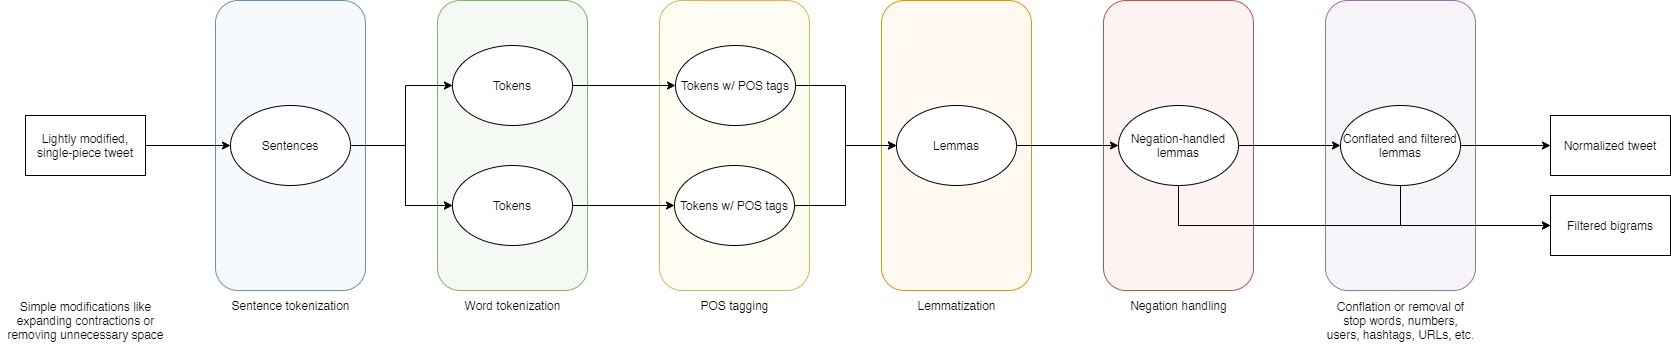

## Sentiment analysis<a id="sentiment"></a>

We can automatically detect the sentiment of words (and therefore sentences) without the need of manually reading labeling all the data. This can be especially useful for contents that target specific products or people, but we can apply this to our dataset as well. Sentiment analysis can be done using  We will simply use NLTK's sentiment analyzer that uses [VADER tool and lexicon](https://www.semanticscholar.org/paper/VADER%3A-A-Parsimonious-Rule-Based-Model-for-Analysis-Hutto-Gilbert/bcdc102c04fb0e7d4652e8bcc7edd2983bb9576d). Lexicons are collections of words designed for specific purposes and making sense of textual data in general. They can be about sentiments, emotions, or other purpose-specific words (plants, animals, etc.). We could collect positive words (such as "nice" and "wonderful") in a file, and check if a sentence has words from that file, indicating whether they are associated with positive sentiments. This would be our positive words lexicon. Alternatively, we could collect words that have a sentiment value (valence), and assign sentiment scores for them. So, we could assign "great" to "1" (positive) and "terrible" to "-1" (negative). VADER actually works like this. It is a word list that is manually rated by different individuals to obtain mean sentiment scores for each word. Naturally, there are other things to consider as well. For example, apart from negation, the existence of certain words also modify the sentiment's intensity ("bad" becomes even more negative with the word "very"). VADER handles these (and more) for us, so we can simply tokenize sentences and feed them to the analyzer to retrieve the normalized (between -1 and 1) sentence-level sentiment scores:

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

# Notice how sentiment scores differ for the following sentences:
sentences = ["It looks VERY BAD!!!", 
             "It looks VERY BAD.", 
             "It looks very bad.", 
             "It looks bad.", 
             "It does not look very bad.", 
             "It does not look bad.", 
             "It looks good.", 
             "It looks good!", 
             "It looks VERY BAD!!! It looks good!"]

for sentence in sentences:
    # It retrieves separate scores for negativity, neutrality, and positivity, but we 
    # can generally simply use the compound score as well.
    print(sentence,sentiment_analyzer.polarity_scores(sentence))

It looks VERY BAD!!! {'neg': 0.672, 'neu': 0.328, 'pos': 0.0, 'compound': -0.7984}
It looks VERY BAD. {'neg': 0.637, 'neu': 0.363, 'pos': 0.0, 'compound': -0.7398}
It looks very bad. {'neg': 0.558, 'neu': 0.442, 'pos': 0.0, 'compound': -0.5849}
It looks bad. {'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}
It does not look very bad. {'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.4708}
It does not look bad. {'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.431}
It looks good. {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
It looks good! {'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.4926}
It looks VERY BAD!!! It looks good! {'neg': 0.449, 'neu': 0.349, 'pos': 0.202, 'compound': -0.6733}


It is decent especially considering its ease of use. Note that the last example does not work so well, because we did not separate those two sentences.

We can write a function that separates the sentences, computes their sentiment scores, and averages those scores:

In [38]:
# This function optionally takes tokenizer and analyzer objects. This is not needed, 
# but it can help with portability.
def analyze_sentiment(tweet, sentence_tokenizer=nltk.data.load('tokenizers/punkt/english.pickle'), 
                      sentiment_analyzer=SentimentIntensityAnalyzer()):
    
    # Sentences are tokenized:
    sentences = sentence_tokenizer.tokenize(tweet)
    
    # Remember that tweets have hashtags, URLs, etc. that may confuse sentiment 
    # analysis process and pull the sentiment towards the middle. A sentiment score 
    # is not retrieved if the sentence has no sentiment and it has less than four
    # tokens (including punctuation). So that a URL would not affect the sentiment 
    # while genuinely neutral sentences, given that they are long enough, would not
    # be disregarded. Some of the processes we have used (such as URL removal) could
    # be applied here as well. Feel free to play with its logic.
    sentiments = [sentiment_analyzer.polarity_scores(sentence)["compound"] for sentence in sentences 
                  if sentiment_analyzer.polarity_scores(sentence)["compound"] != 0 or len(tokenizer.tokenize(sentence)) > 3]
    
    # Returns the average compound sentiment score if a sentiment is detected.
    if sentiments:
        return sum(sentiments)/len(sentiments)
    # Returns 0 if a sentiment is not detected:
    else:
        return 0
    
# One sentence is negative and the other is positive while the general tone is closer
# to being negative:
analyze_sentiment("It looks VERY BAD!!! It looks good!", sentence_tokenizer, sentiment_analyzer)

-0.1529

This is much better. We can now apply this function the dataset and obtain the average sentiment score of each tweet:

In [39]:
dataset["sentiment"] = dataset["text"].map(analyze_sentiment)

dataset[["text", "sentiment"]].head(25)

,text,sentiment
0,Praying for good health and recovery of @ChouhanShivraj . #covid19 #covidPositive,0.65970
1,July 25 #COVID19 update #TamilNadu - 6988 Discharge- 7758 People tested - 61729 Actice cases - 52273 #chennai - 1329,0.00000
2,Second wave of #COVID19 in Flanders..back to more #homework again... https://t.co/9swImZACMN,0.00000
3,Holy water in times of #COVID19 https://t.co/YaZ49yxL27,0.00000
4,#FEMA acknowledges #PuertoRico lacks rebuilt homes and a hospital to survive #COVID19 https://t.co/PLXqKc5K5d,0.00000
5,Actionables for a healthy recovery from #COVID19 #climate https://t.co/crGlKZOz5Z,0.40190
6,Volume for those at the back please. 🔊 #COVID19 https://t.co/d0pn2Bv2Hx,0.31820
7,Why has Ruto not eulogisied Mkapa!! Asking for Moses Kuria Raila #RutoSwindlingGEMA #COVID19,0.00000
8,Crazy that the world has come to this but as Americans we will fight to get through this!🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 #covid19,-0.65880
9,@jimsciutto @JoAnnBaldwin55 People whose relatives have died from #COVID19 should file a class action lawsuit against Sinclair Broadcasting.,-0.67050


It is not perfect as you can see, but it is much more reliable at the extremes:

In [40]:
# Combines the most positive and negative 10 tweets together:
dataset[["text", "sentiment"]].sort_values(by=['sentiment']).head(10).append(dataset[["text", "sentiment"]].sort_values(by=['sentiment']).tail(10))

,text,sentiment
34980,@OfficialRedSide @MSNBC Just the fake president who raped women is a racist and does not care about the people that died of #COVID19,-0.9579
20590,"Failure after failure, lie after lie by this stinking, rotten corrupt shower of shit we have for a Govt. #COVID19 https://t.co/IhkenBP2Hg",-0.9552
35399,Violence and abuse against shop workers doubles during #COVID19 pandemic - wtf is wrong with people!! https://t.co/xBckn6IBNq,-0.9500
31704,https://t.co/m3B4eKyGTg Sighhhhhhhhhhhhhhhhhhh :( :( :( :( :( :( #covid19,-0.9468
36,"@TheDailyEdge @seanhannity @FoxNews So he can spread lies, hate, sexual violence, and murder. #COVID19 #FoxNews",-0.9460
4809,"#COVID19 has really become boring o, next year we want walking dead, evil dead, werewolves and vampires 🤣🤣🤣🤣 #BBNaijia2020",-0.9458
2225,Not so fun fact: More Americans have died from #Covid19 than were killed during the entire Vietnam war. #CoronaVirus #CoronaVirusPandemic,-0.9449
14787,@matthaig1 Also it is friggin stupid because from all accounts #COVID19 is a horrible scary drawn-out way to die.,-0.9359
9525,#COVID19 and Suicide: A Crisis Within a Crisis #MentalHealthMonday #MentalHealthMatters #MentalHealth https://t.co/XbHu4srCLF,-0.9287
38477,"@scott_ipod 182,000 DEAD AMERICANS MURDERED BY #TrumpsAmerica due to ignorance in a #COVID19 pandemic = 62 x 9/11's",-0.9283


We can now use these sentiment scores with other analyses. You are encouraged to explore these tweets and other methods for analysis.

Note that there are some important limitations. A word can have different meanings in different domains/contexts. Consider these sentences:

* This song is **sick**. → Nice.👍
* This child is **sick**. → Not nice.👎

Sometimes, a word can have one meaning yet different implications. Consider these sentences:

* The patient had a **positive** experience. → Nice.👍
* The patient had a **positive** test result for COVID-19. → Not nice.👎

You might want to make adjustments or use your own lexicon for a specific topic/task. You can also train a model to guess the sentiment. [Check](https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386) this example.

If you are interested in lexicon-based approaches, take a look at [EmoLex](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), a lexicon for emotions and sentiment. It can be used to automatize emotion detection. It also has Turkish words (along with some other languages), but they are an automatic translation, so they are not as reliable. You can now directly download it from its web page.

## Bonus: Levenshtein distance<a id="levenshtein"></a>

As mentioned above, a simple autocorrection process can be applied using the Levenshtein distance. Let us see what that means. 

Consider the words `cup` and `cap`. Their Levenshtein distance is 1, because we can obtain one from the other by simply substituting a character. For two given strings, we can calculate the number of operations required (edit distance) to obtain one from the another. These operations are:

* Insertion: Inserting a character to a specific location in the string.
    * "up" becomes "**c**up"
* Deletion: Deleting a character from a specific location in the string.
    * "cu**s**p" becomes "cup"
* Substitution: Substituting a character in a specific location in the string with another character.
    * "c**u**p" becomes "c**a**p"
* Transpotisition (this is later introduced by an extension, the Damerau-Levenstein distance algorithm): Switching the positions of two adjacent characters.
    * "c**pu**" becomes "c**up**"
    
Using these, for a given word, we can find the closest word from a dictionary that would require the least amount of changes. This is a costly process, so it is usually limited to certain amount of changes. See [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) for more information.

We can also use this distance to calculate the similarity between two strings. This is handy for fuzzy string matching, when the same thing can be represented in similar yet different forms. This is quite common in neighborhood or street names in Turkey. By setting a similarity threshold and looking at their similarity, we can match addresses like `Kemalpaşa Mah.` and `Kemal Paşa Mahallesi`.

In [41]:
import Levenshtein

string_a = "Kemalpaşa Mah."
string_b = "Kemal Paşa Mahallesi"

Levenshtein.ratio(string_a, string_b)
# Note that you would probably want to remove "mahallesi" or "mah." when your task is 
# address matching. It would significantly increase your success.

0.7058823529411765

A use case for our dataset could be finding tweets that are similar to each other. Let us search for a tweet pair that has the highest similarity without being exactly the same:

In [42]:
pair = None
highest = 0

tweets_to_compare = 100
# To compare all the tweets, uncomment this line. Note that it would take much longer.
# tweets_to_compare = dataset.shape[0]

# This compares each tweet with the ones that come after itself, which takes some time.
for i in range(0, tweets_to_compare-1):
    for j in range(1, tweets_to_compare):
        # If the tweets are not the same:
        if dataset.loc[i,"text"] != dataset.loc[j,"text"]:
            similarity = Levenshtein.ratio(dataset.loc[i,"text"], dataset.loc[j,"text"])
            # If their similarity is higher than the previous similarities:
            if similarity > highest:
                highest = similarity
                pair = (dataset.loc[i,"text"], dataset.loc[j,"text"])
                
print("The most similar tweet pair:", pair)
print("Similarity", highest)

The most similar tweet pair: ('395 new cases and 3 new deaths in Uzbekistan [13:22 GMT] #coronavirus #CoronaVirusUpdate #COVID19 #CoronavirusPandemic', '1,005 new cases and 18 new deaths in the United States [13:16 GMT] #coronavirus #CoronaVirusUpdate #COVID19 #CoronavirusPandemic')
Similarity 0.8699186991869918


## Bonus: NLP in Turkish<a id="tr"></a>

From a linguistic perspective, Turkish is a fascinating language with its rather strict grammatical rules. However, due to its agglutinative nature, words can easily become complex with many affixes and inflections. This can make morphological analyses harder compared to English.

### Stemming<a id="tr-stem"></a>

[snowballstemmer](https://pypi.org/project/snowballstemmer/) has a Turkish stemmer:

In [43]:
from snowballstemmer import TurkishStemmer

stemmer_tr = TurkishStemmer()

sentence = "Gözleme gözleyen gözlüklü gözcü gözden düştü."

[stemmer_tr.stemWord(token) for token in tokenizer.tokenize(sentence)]

['gözle', 'gözleye', 'gözlüklü', 'gözcü', 'göz', 'düş', '.']

### POS tagging and lemmatization<a id="tr-pos-lemma"></a>

It looks like the morphological analyzer of [Zemberek](https://github.com/ahmetaa/zemberek-nlp), the famous Turkish NLP tool for Java, has been unofficially ported to Python as [zeyrek](https://github.com/obulat/zeyrek/). It does not have all of its original features (like disambiguation and more), but we can still use it to morphologically analyze a word, sentence, or sentences:

In [44]:
from zeyrek import MorphAnalyzer

analyzer = MorphAnalyzer()

analyzer.analyze(sentence)

# This also explicitly returns tokenized sentences if you prefer:
# analyzer._analyze_text(sentence)

[[Parse(word='Gözleme', lemma='gözlemek', pos='Verb', morphemes=['Verb', 'Neg', 'Imp', 'A2sg'], formatted='[gözlemek:Verb] gözle:Verb+me:Neg+Imp+A2sg'),
  Parse(word='Gözleme', lemma='gözlem', pos='Noun', morphemes=['Noun', 'A3sg', 'Dat'], formatted='[gözlem:Noun] gözlem:Noun+A3sg+e:Dat'),
  Parse(word='Gözleme', lemma='Gözlem', pos='Noun', morphemes=['Noun', 'A3sg', 'Dat'], formatted='[Gözlem:Noun,Prop] gözlem:Noun+A3sg+e:Dat'),
  Parse(word='Gözleme', lemma='gözleme', pos='Noun', morphemes=['Noun', 'A3sg'], formatted='[gözleme:Noun] gözleme:Noun+A3sg'),
  Parse(word='Gözleme', lemma='gözlemek', pos='Noun', morphemes=['Verb', 'Inf2', 'Noun', 'A3sg'], formatted='[gözlemek:Verb] gözle:Verb|me:Inf2→Noun+A3sg')],
 [Parse(word='gözleyen', lemma='gözlemek', pos='Adj', morphemes=['Verb', 'PresPart', 'Adj'], formatted='[gözlemek:Verb] gözle:Verb|yen:PresPart→Adj')],
 [Parse(word='gözlüklü', lemma='gözlük', pos='Adj', morphemes=['Noun', 'A3sg', 'With', 'Adj'], formatted='[gözlük:Noun] gözlük:N

Since some words can have different morphological explanations, every alternative is retrieved. From this, we can obtain lemmas and POS tags as you can see. However, simply using the first explanation for a word may not yield the correct result:

In [45]:
for word in analyzer.analyze(sentence):
    print("Token:",word[0].word,"\nPOS:",word[0].pos,"\nLemma:",word[0].lemma,"\n")

Token: Gözleme 
POS: Verb 
Lemma: gözlemek 

Token: gözleyen 
POS: Adj 
Lemma: gözlemek 

Token: gözlüklü 
POS: Adj 
Lemma: gözlük 

Token: gözcü 
POS: Noun 
Lemma: gözcü 

Token: gözden 
POS: Noun 
Lemma: göz 

Token: düştü 
POS: Verb 
Lemma: düşmek 

Token: . 
POS: Punc 
Lemma: . 



We can also simply use `analyzer.lemmatize()` to lemmatize the words. Again, it returns all possible lemmas without disambiguation:

In [46]:
analyzer.lemmatize(sentence)

[('Gözleme', ['gözleme', 'Gözlem', 'gözlem', 'gözlemek']),
 ('gözleyen', ['gözlemek']),
 ('gözlüklü', ['göz', 'gözlük']),
 ('gözcü', ['göz', 'gözcü']),
 ('gözden', ['Gözde', 'göz', 'gözde']),
 ('düştü', ['düş', 'düşmek']),
 ('.', ['.'])]

### Dealing with Turkish characters<a id="tr-encoding"></a>

A past Turkish government's short-sightedness in the 80's is haunting programmers who work with Turkish texts to this day. To prevent some Turkish characters from deforming, we need to read and write files using the "UTF-8" encoding. However, this may not be enough if your data is not saved as "UTF-8" in the first place. Sometimes, you may realize that certain characters in your dataset itself is not properly represented. For example, instead of the word `kılıç`, you may see `kÄ±lÄ±Ã§`. This may suggest that your data is saved in "Latin-1" (also known as "ISO 8859-1"), which is the most common encoding in the Western world and the standard for many protocols. To fix it, you can specify the encoding of the string as "latin-1" (or "ISO 8859-1") and then decode it to "UTF-8" as shown below:

In [47]:
badly_encoded = "kÄ±lÄ±Ã§"
encoding_fixed = badly_encoded.encode("latin-1").decode("utf-8")

encoding_fixed

'kılıç'

Hopefully, this will solve your problem. If not, you can also find the deformed characters and write a function that replaces all of those characters with the correct ones. 

Keep in mind that Turkish characters can also cause some packages or languages to raise an error. You may also see that the fonts used by some packages may not support these characters and plot `□` instead. Therefore, you may want to anglicize Turkish characters to prevent these. Here is a function that does that for you.

In [48]:
# Changes all Turkish characters with their simpler versions:
def anglicize_turkish(text):
    return text.translate(text.maketrans({"Ğ": "G", "ğ": "g", "Ü": "U", "ü": "u", "Ş": "S", "ş": "s", "İ": "I", "ı": "i", "Ö": "O", "ö": "o", "Ç": "C", "ç": "c"}))

anglicize_turkish("kılıç")

'kilic'

Another problem is the built-in functions that lowercase or uppercase your text may not work properly with Turkish text, even if your system locale is Turkish. For example, the lowercase version of `KILIÇ` is normally returned as `kiliç`, since "I" corresponds to "i" in the Western languages. Instead of dealing with locales (which may not solve your problem anyway), a simple solution is to manually lowercase/uppercase the problematic letters and then use the built-in function:

In [49]:
def turkish_lowercase(text):
    return text.translate(text.maketrans({"I": "ı"})).lower()

def turkish_uppercase(text):
    return text.translate(text.maketrans({"i": "İ"})).upper()

print("Built-in lowercase for KILIÇ:", "KILIÇ".lower())
print("Custom lowercase for KILIÇ:", turkish_lowercase("KILIÇ"))
print("Built-in uppercase for isim:", "isim".upper())
print("Custom uppercase for isim:", turkish_uppercase("isim"))

Built-in lowercase for KILIÇ: kiliç
Custom lowercase for KILIÇ: kılıç
Built-in uppercase for isim: ISIM
Custom uppercase for isim: İSİM


## More information<a id="more-info"></a>

* [NLTK documentation](https://www.nltk.org/)
* [TextBlob](https://textblob.readthedocs.io/en/dev/): A library written on NLTK. You may want to look at this as well since certain tasks can be easier with TextBlob.
* [spaCy](https://github.com/explosion/spaCy): Another popular NLP library.
* [Stanza](https://stanfordnlp.github.io/stanza/): An NLP library with a language-agnostic pipeline that makes use of neural networks. It also provides an interface for [CoreNLP](https://stanfordnlp.github.io/CoreNLP/), a popular NLP library for Java. It supports Turkish. You can check how it works with Turkish (or any other language) from [here](http://stanza.run/).
* If you are interested in linguistics, you can take a look at [the course catalog of Cognitive Science Department at METU](https://catalog.metu.edu.tr/prog_courses.php?prog=902) as they have some specialized courses.
* [Social media text normalization for Turkish](https://www.cambridge.org/core/journals/natural-language-engineering/article/social-media-text-normalization-for-turkish/6BADFEB835E28ABC03CDC472B2BAA6AB)

If you have questions, feel free to send an e-mail.